<a href="https://colab.research.google.com/github/justinbkeeler/2023-NAA-Student/blob/main/24_0612_BSAN790A_RCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BSAN 790A - Causal Inference

In [24]:
import pandas as pd # for data manipulation
import numpy as np # for numerical computation

data = pd.read_csv("https://raw.githubusercontent.com/justinbkeeler/causal-inference-in-python-code/main/causal-inference-in-python/data/cross_sell_email.csv")
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


In [25]:
(data.groupby(["cross_sell_email"]).mean()) # data in the dataframe is grouped by the "cross_sell_email" variable, the mean of all other variables are are computed

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [26]:
X = ["gender", "age"] # object called X which only contains the variables of "gender" and "age"

mu = data.groupby("cross_sell_email")[X].mean() # creating a variable object called mu, calculating the mean, specific to [X] object
var = data.groupby("cross_sell_email")[X].var() # creating a variable object called var, calculating the variance, , specific to [X] object, e.g. sigma (xi - mu)^2

norm_diff = ((mu - mu.loc["no_email"])/
             np.sqrt((var + var.loc["no_email"])/2))

norm_diff

,gender,age
cross_sell_email,,
long,0.015802,0.221423
no_email,0.000000,0.000000
short,0.184341,0.087370


**Interpreting Normalized Differences**

*   Small Normalized Difference (e.g., close to 0): Indicates that the groups are similar with respect to that covariate.
*   Large Normalized Difference (e.g., > 0.1 or < -0.1): Indicates a significant difference between the groups for that covariate, suggesting potential imbalance.

By using normalized differences, you enhance the robustness and credibility of your findings, ensuring that observed effects are more likely attributable to the treatment rather than pre-existing differences between groups.

## Compare Differences Using ANOVA (Analysis of Variance)

In [27]:
# Step 1: Import/load statsmodels.api library
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
# Step 2: Create an object called, "model" using the ols function
model = ols('conversion ~ C(cross_sell_email)', data = data).fit() # C means to treat the "cross_sell_email" as a categorical variable, "conversion is the outcome variable"

In [29]:
# Step 3: Create the anova object and table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq     df        F    PR(>F)
C(cross_sell_email)   0.440503    2.0  3.11523  0.045717
Residual             22.624512  320.0      NaN       NaN


**Check the PR(>F) variable**  
If this is less than .05, there is likely a significant difference occuring between some of the categories

In [30]:
# Step 4: If significant, P-value, perform post hoc analysis, e.g. pairwise contrast
from statsmodels.stats.multicomp import pairwise_tukeyhsd # TukeyHSD is most common; however, there are assumptions that have to be met first because there are other variations for pairwise

tukey = pairwise_tukeyhsd(endog=data['conversion'],
                          groups = data['cross_sell_email'],
                          alpha = 0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    long no_email  -0.0125 0.9404 -0.1006 0.0756  False
    long    short     0.07 0.1167 -0.0129 0.1528  False
no_email    short   0.0824 0.0644 -0.0038 0.1687  False
-------------------------------------------------------


## The Most Dangerous Equation

In [31]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from cycler import cycler
import matplotlib

default_cycler = (cycler(color=['0.1', '0.5', '1.0']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

matplotlib.rcParams.update({'font.size': 18})

In [32]:
df = pd.read_csv("https://raw.githubusercontent.com/justinbkeeler/causal-inference-in-python-code/main/causal-inference-in-python/data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Text(0.5, 1.0, 'Number of Students of 1% Top Schools (Right)')

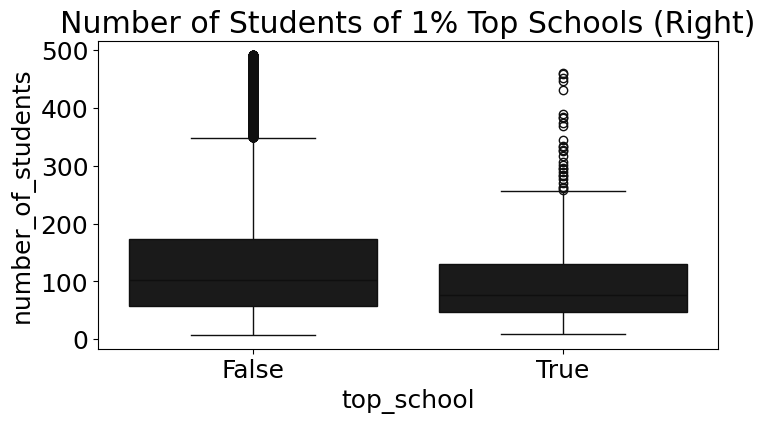

In [33]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(8,4))
ax = sns.boxplot(x="top_school", y="number_of_students", data=plot_data)

plt.title("Number of Students of 1% Top Schools (Right)")

Text(0.5, 1.0, 'ENEM Score by Number of Students in the School')

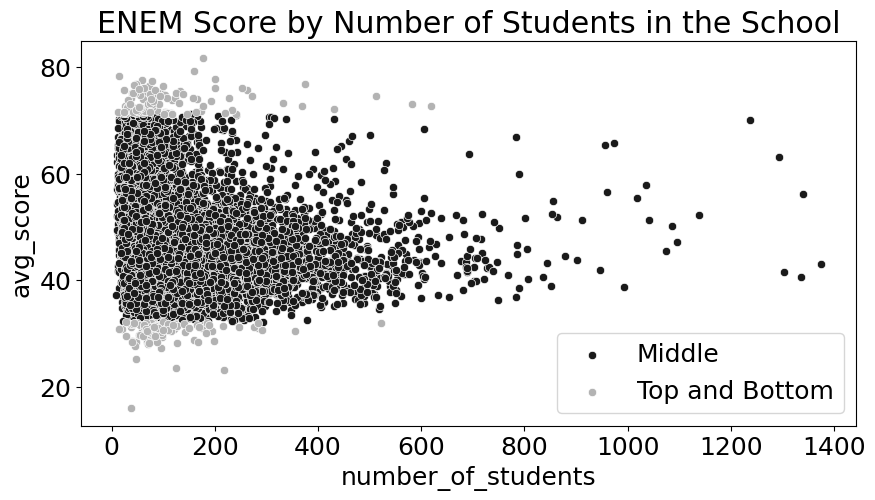

In [34]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([(d["avg_score"] > q_99) | (d["avg_score"] < q_01)],
                                                 ["Top and Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group=='Middle'"), label="Middle")
ax = sns.scatterplot(y="avg_score", x="number_of_students", data=plot_data.query("Group!='Middle'"), color="0.7", label="Top and Bottom")

plt.title("ENEM Score by Number of Students in the School")

**Interpretation/Impression:**

*   The plot might suggest that smaller schools exhibit more variability in average ENEM scores, possibly due to individual performances having a more significant impact in smaller cohorts.
*   Larger schools tend to have more stable, average performances, likely due to the larger sample size evening out the extreme performances.
*   Trendwise...As the number of students in schools increases, the scores tend to converge towards the middle range, reducing the variability observed in smaller schools.






    

##  The Standard Error of Our Estimates

In [35]:
# data objects are being created from the above "data" object
short_email = data.query("cross_sell_email=='short'")["conversion"]
long_email = data.query("cross_sell_email=='long'")["conversion"]
email = data.query("cross_sell_email!='no_email'")["conversion"]
no_email = data.query("cross_sell_email=='no_email'")["conversion"]

data.groupby("cross_sell_email").size()

cross_sell_email
long        109
no_email     94
short       120
dtype: int64

**What is the code doing?**


*   Query Function: The query() function is used to filter rows from the DataFrame based on a condition. For instance, data.query("cross_sell_email=='short'") filters the DataFrame to include only those rows where the value of the cross_sell_email column equals 'short'. The query is further narrowed down to only consider the 'conversion' column with the indexing ["conversion"]. This is repeated for 'long', and 'no_email' conditions as well.
*   Groupby and Size Function: After defining the subsets (short_email, long_email, no_email), the original DataFrame data is grouped by the cross_sell_email column using groupby("cross_sell_email"). The size() function is then called on these grouped data to count the number of entries in each group. This is effectively calculating the number of records for each type of cross_sell_email (short, long, no_email) in the entire dataset.

The output below from the code:

    long: 109
    no_email: 94
    short: 120

These numbers are counts of how many entries exist in the dataset for each type of cross_sell_email.

Essentially, the code is used to analyze how many entries there are for each category of cross_sell_email and the individual queries are used to create subsets of data for further specific analysis, if needed.

In [36]:
def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Long Email:", se(long_email))
print("SE for Short Email:", se(short_email))

SE for Long Email: 0.021946024609185506
SE for Short Email: 0.030316953129541618


## Confidence Intervals

In [37]:

n = 100
conv_rate = 0.08

def run_experiment():
    return np.random.binomial(1, conv_rate, size=n)

np.random.seed(42)

experiments = [run_experiment().mean() for _ in range(10000)]

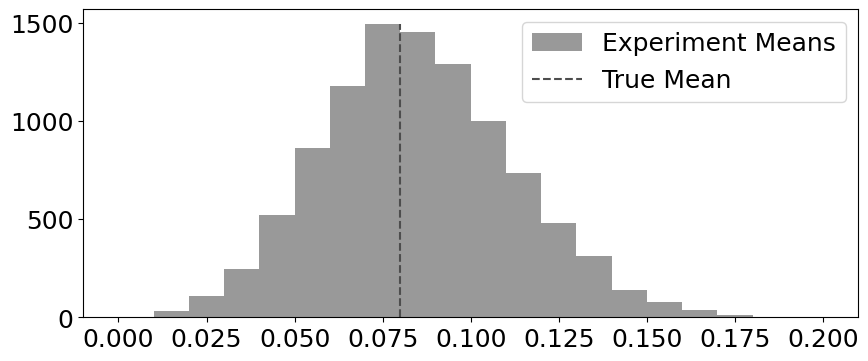

In [38]:
plt.figure(figsize=(10,4))
freq, bins, img = plt.hist(experiments, bins=20, label="Experiment Means", color="0.6")
plt.vlines(conv_rate, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="0.3")
plt.legend()

(array([92.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

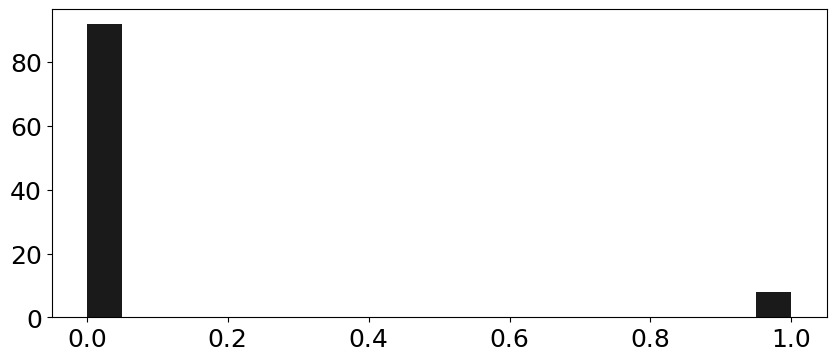

In [39]:
np.random.seed(42)
plt.figure(figsize=(10,4))
plt.hist(np.random.binomial(1, 0.08, 100), bins=20)

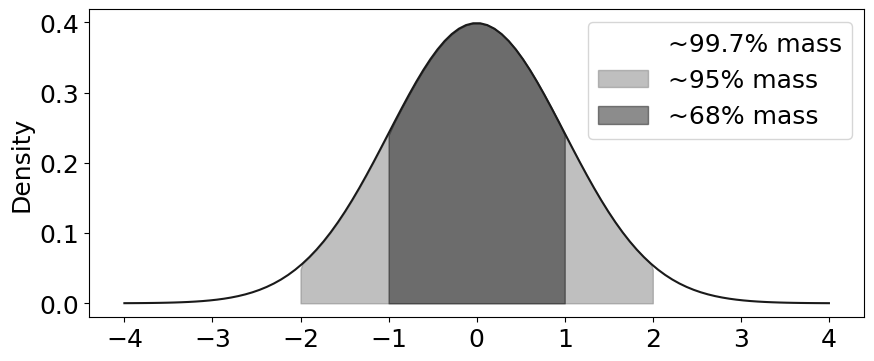

In [47]:
x = np.linspace(-4, 4, 100)
y = stats.norm.pdf(x, 0, 1)

plt.figure(figsize=(10,4))
plt.plot(x, y, linestyle="solid")
plt.fill_between(x.clip(-3, +3), 0, y, alpha=0.5, label="~99.7% mass", color="C2")
plt.fill_between(x.clip(-2, +2), 0, y, alpha=0.5, label="~95% mass", color="C1")
plt.fill_between(x.clip(-1, +1), 0, y, alpha=0.5, label="~68% mass", color="C0")
plt.ylabel("Density")
plt.legend()

In [48]:
exp_se = short_email.sem()
exp_mu = short_email.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print("95% CI for Short Email: ", ci)

95% CI for Short Email:  (0.06436609374091676, 0.18563390625908324)


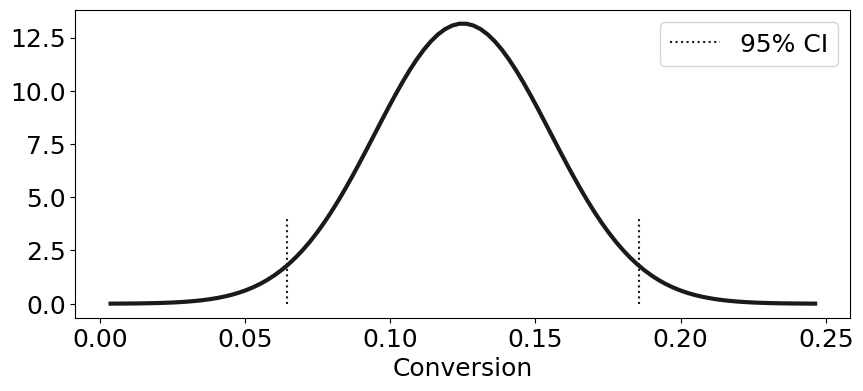

In [49]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [50]:
from scipy import stats

z = np.abs(stats.norm.ppf((1-.99)/2))
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(0.04690870373460816, 0.20309129626539185)

In [51]:
stats.norm.ppf((1-.99)/2)

-2.5758293035489004

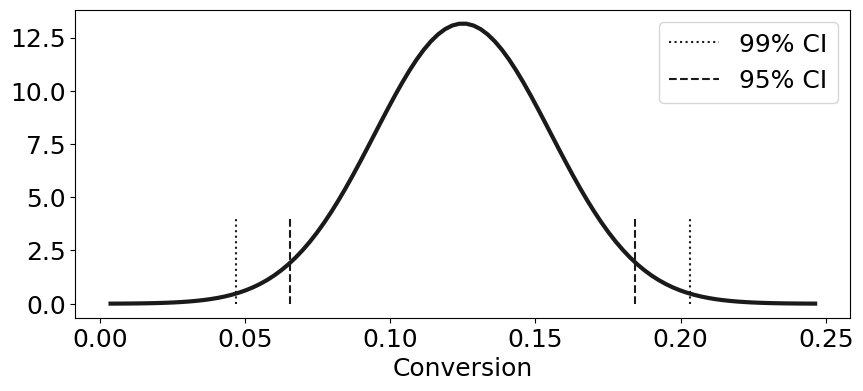

In [56]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)

plt.figure(figsize=(10,4))
plt.plot(x, y, lw=3)
plt.vlines(ci[1], ymin=0, ymax=4, ls="dotted")
plt.vlines(ci[0], ymin=0, ymax=4, ls="dotted", label="99% CI")


ci_95 = (exp_mu - 1.96 * exp_se, exp_mu + 1.96 * exp_se)

plt.vlines(ci_95[1], ymin=0, ymax=4, ls="dashed")
plt.vlines(ci_95[0], ymin=0, ymax=4, ls="dashed", label="95% CI")
plt.xlabel("Conversion")
plt.legend()

In [57]:
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem())

print("95% CI for Short Email:", ci(short_email))
print("95% CI for Long Email:", ci(long_email))
print("95% CI for No Email:", ci(no_email))

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.01115382234126202, 0.09893792077800403)
95% CI for No Email: (0.0006919679286838468, 0.08441441505003955)


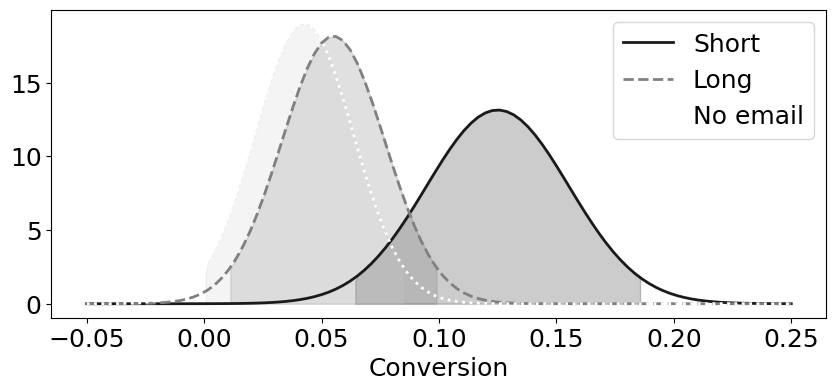

In [58]:
plt.figure(figsize=(10,4))

x = np.linspace(-0.05, .25, 100)
short_dist = stats.norm.pdf(x, short_email.mean(), short_email.sem())
plt.plot(x, short_dist, lw=2, label="Short", linestyle=linestyle[0])
plt.fill_between(x.clip(ci(short_email)[0], ci(short_email)[1]), 0, short_dist, alpha=0.2, color="0.0")

long_dist = stats.norm.pdf(x, long_email.mean(), long_email.sem())
plt.plot(x, long_dist, lw=2, label="Long", linestyle=linestyle[1])
plt.fill_between(x.clip(ci(long_email)[0], ci(long_email)[1]), 0, long_dist, alpha=0.2, color="0.4")

no_email_dist = stats.norm.pdf(x, no_email.mean(), no_email.sem())
plt.plot(x, no_email_dist, lw=2, label="No email", linestyle=linestyle[2])
plt.fill_between(x.clip(ci(no_email)[0], ci(no_email)[1]), 0, no_email_dist, alpha=0.2, color="0.8")

plt.xlabel("Conversion")
plt.legend()


**Dr. Keeler's Think About It Moment...**  

Unless one distribution's 95-99% [2.5% - 1.25% on the tail] CI (lower or upper) crosses another distribution's 95%-99% CI (lower or upper), it will be non significant. This is because both needing to cross within the range. If one's 95% CI crosses the plane above another's lower 95% CI or below the other's higher 95% CI, it will not be significant. Alternatively, for greater significant, apply this thinking for 99% [1.25%...] CI to the other's 99% [1.25%...] respective CI.

In [59]:
# Using standard error to derive the CIs
def ci(y: pd.Series):
    return (y.mean() - 2 * y.sem(), y.mean() + 2 * y.sem()) # .mean = mean of variable array, .sem = standard error of the mean

print("95% CI for Short Email:", ci(short_email)) # the ci function is being applied to the short_email object
print("95% CI for Long Email:", ci(long_email))   # the ci function is being applied to the long_email object
print("95% CI for No Email:", ci(no_email))       # the ci function is being applied to the no_email object

95% CI for Short Email: (0.06436609374091676, 0.18563390625908324)
95% CI for Long Email: (0.01115382234126202, 0.09893792077800403)
95% CI for No Email: (0.0006919679286838468, 0.08441441505003955)


Explanation of **y: pd.Series** function

*   y is the name of the parameter that the function ci expects to receive.
*   pd.Series specifies that y is expected to be a pandas Series object. This is a one-dimensional array capable of holding any data type with axis labels, which comes from the pandas library. By specifying pd.Series, the function indicates that it is designed to operate on a pandas Series, which is typically a column of data from a DataFrame.


    
    

## Revisit From Prior Analyses

In [60]:
(data.groupby(["cross_sell_email"]).mean()) # data in the dataframe is grouped by the "cross_sell_email" variable, the mean of all other variables are are computed

,gender,age,conversion
cross_sell_email,,,
long,0.550459,21.752294,0.055046
no_email,0.542553,20.489362,0.042553
short,0.633333,20.991667,0.125000


In [61]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                        sum_sq     df        F    PR(>F)
C(cross_sell_email)   0.440503    2.0  3.11523  0.045717
Residual             22.624512  320.0      NaN       NaN


In [62]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd # TukeyHSD is most common; however, there are assumptions that have to be met first because there are other variations for pairwise

tukey = pairwise_tukeyhsd(endog=data['conversion'],
                          groups = data['cross_sell_email'],
                          alpha = 0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    long no_email  -0.0125 0.9404 -0.1006 0.0756  False
    long    short     0.07 0.1167 -0.0129 0.1528  False
no_email    short   0.0824 0.0644 -0.0038 0.1687  False
-------------------------------------------------------
